In [1]:
% pylab inline
import os
# os.system("export CUDA_VISIBLE_DEVICES")="3"
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
try:
    from moviepy.video.io.bindings import mplfig_to_npimage
    import moviepy.editor as mpy
    generate_movie = True
except:
    print("Warning: moviepy not found.")
    generate_movie = False

slim = tf.contrib.slim
ds = tf.contrib.distributions

Populating the interactive namespace from numpy and matplotlib


/home/houssam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print(tf.__version__)

1.5.0



### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [3]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [4]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

In [5]:
def load_mnist_and_sample(batch_size):
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    from sampler import sampler
    
    im=mnist.train.next_batch(1)[0]
    im=im.reshape([28,28])
    
    x = np.linspace(0, 1, 28)
    y = np.linspace(0, 1,28)
    xv, yv = np.meshgrid(x, y)
    z=im
    s=sampler(x,y,z)
    vals = s.sample(batch_size)
    
    return vals,im
    
def plot_vals_im(vals,im):
    xVals = []; yVals = []
    fig, ax = plt.subplots(nrows=1, ncols=2)
    for item in vals:  # plot point by point
            xVals.append(item[0])
            yVals.append(item[1])
            ax[0].plot(item[0], 1-item[1], marker="x", c="red")
            ax[0].set_title('Complex distribution')
    
    ax[1].imshow(im,cmap='gray')
    ax[1].set_title('Original Image')
    plt.show()

def sample_complex(batch_size):
    vals, im = load_mnist_and_sample(batch_size)
    plot_vals_im(vals,im)
    
    return tf.stack(vals)

### Hyperparam

In [6]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=80,
    frame_every=1, 
    viz_every=20,
    z_dim=256,
    x_dim=2,
    optimizer='sga', # rmsprop sgd sga
    align = True,
    data = 'mog',
)

## Function for Symplectic gradient adjustment

In [7]:
def jac_vec(ys,xs,vs):
    return fwd_gradients(ys,xs,grad_xs=vs, stop_gradients=xs)

def jac_tran_vec(ys,xs,vs):
    dydxs = tf.gradients(ys,xs,grad_ys=vs, stop_gradients=xs)
    return [tf.zeros_like(x) if dydx is None else dydx for (x,dydx) in zip(xs,dydxs)]

def get_sym_adj(Ls,xs):
    xi= [tf.gradients(l,x)[0]for(l,x)in zip(Ls,xs)]
    H_xi = jac_vec(xi,xs,xi)
    Ht_xi = jac_tran_vec(xi,xs,xi)
    At_xi =[(ht-h)/2 for (h,ht) in zip(H_xi,Ht_xi)]
    return At_xi

## Construct model and training ops

In [8]:
tf.reset_default_graph()

data = sample_mog(params['batch_size']) if params['data']=='mog' else sample_complex(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

if params['optimizer'] == 'rmsprop':
    d_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
    d_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    
elif params['optimizer'] == 'sgd':    
    d_train_opt = tf.train.GradientDescentOptimizer(params['gen_learning_rate'])
    g_train_opt = tf.train.GradientDescentOptimizer(params['gen_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    
elif params['optimizer'] == 'sga': 
    d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
    g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])

    dvs = d_opt.compute_gradients(loss, var_list=disc_vars)
    gvs = g_opt.compute_gradients(-loss, var_list=gen_vars)

    adj = get_sym_adj([loss]*len(disc_vars) + [-loss]*len(gen_vars),disc_vars+
                      gen_vars)
    d_adj= adj[:len(disc_vars)]
    g_adj = adj[-len(gen_vars)::]

    if params['align']:
        xsi_d = [grad for (grad,var) in dvs]
        sq_xsi_d = 0.5*tf.reduce_sum([tf.reduce_sum(tf.square(grad)) for grad in xsi_d])
        grad_h_d = d_opt.compute_gradients(sq_xsi_d, var_list=disc_vars)
        xsi_g = [grad for (grad,var) in gvs]
        sq_xsi_g = 0.5*tf.reduce_sum([tf.reduce_sum(tf.square(grad)) for grad in xsi_g])
        grad_h_g = g_opt.compute_gradients(sq_xsi_g, var_list=gen_vars)
        
        grad_h = grad_h_d + grad_h_g
        grad_h = [grad for (grad,var) in grad_h]
        xsi = xsi_d + xsi_g
        d = len(xsi)

        dot_xsi_grad_h = tf.reduce_sum([tf.reduce_sum(a*b) for a,b in zip(xsi,grad_h)])
        dot_adj_grad_h = tf.reduce_sum([tf.reduce_sum(a*b) for a,b in zip(adj,grad_h)])
        mul_dot = dot_xsi_grad_h*dot_adj_grad_h
        
        lambd = tf.sign(mul_dot/d + 1/10)
    else:
        lambd = tf.constant(1)
        
    dvs_sga = [(grad + lambd*adj , var) for (grad,var),adj in zip(dvs,d_adj)]
    gvs_sga = [(grad + lambd*adj , var) for (grad,var),adj in zip(gvs,g_adj)]
    
    d_train_op = d_opt.apply_gradients(dvs_sga)
    g_train_op = g_opt.apply_gradients(gvs_sga)

## Train

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/81 [00:00<?, ?it/s]

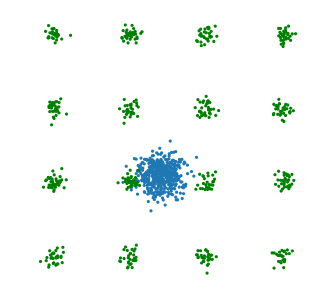

 25%|██▍       | 20/81 [01:20<03:50,  3.78s/it]

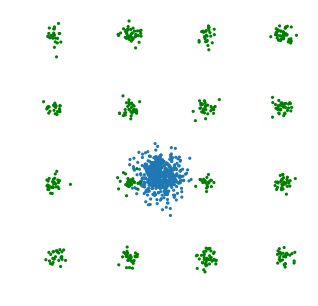

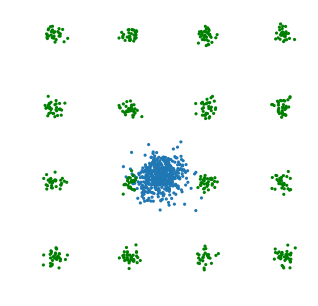

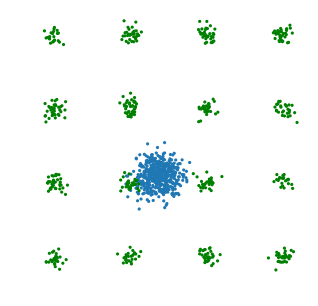

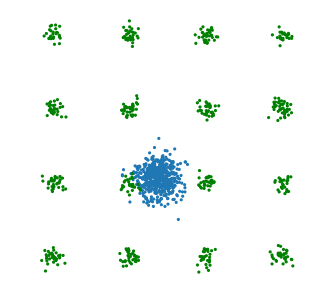

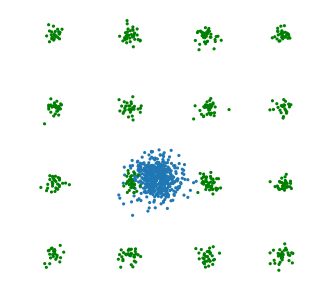

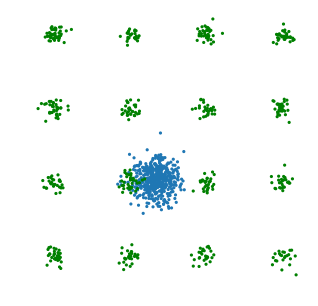

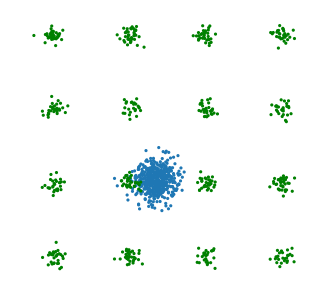

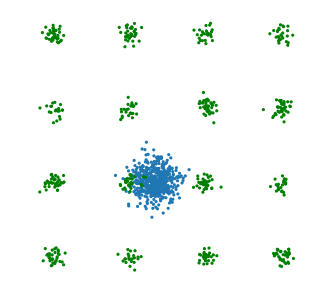

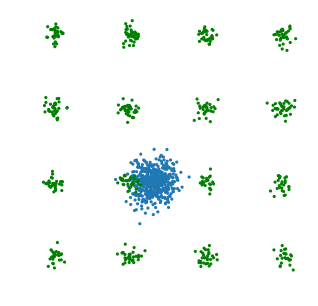

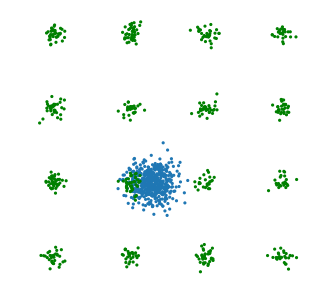

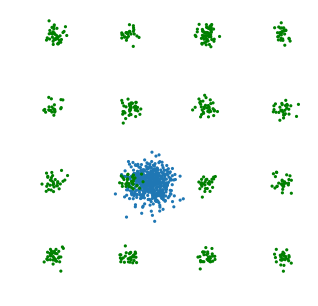

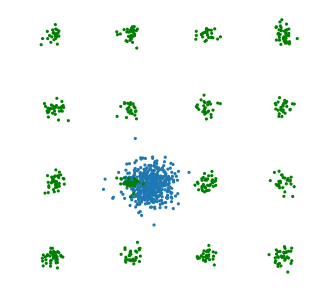

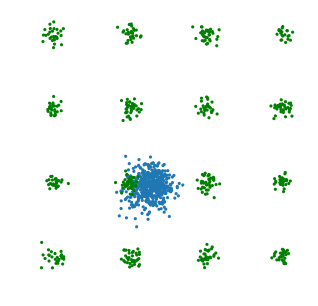

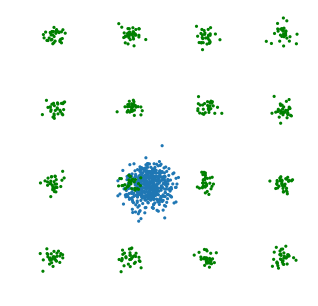

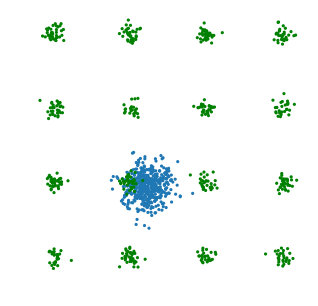

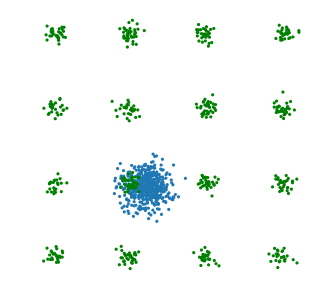

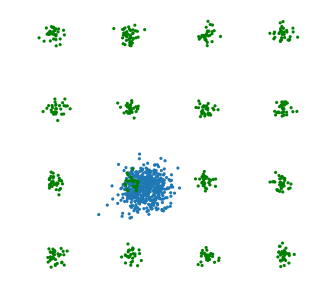

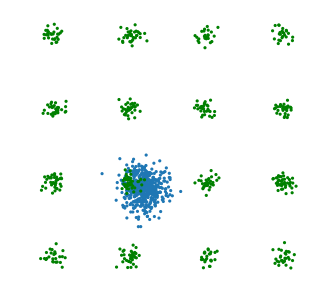

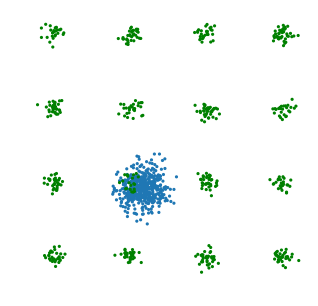

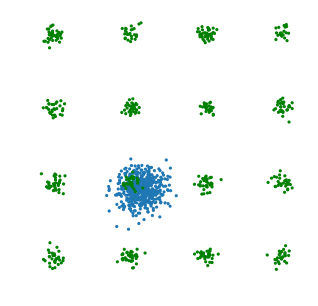

 49%|████▉     | 40/81 [02:37<02:31,  3.70s/it]

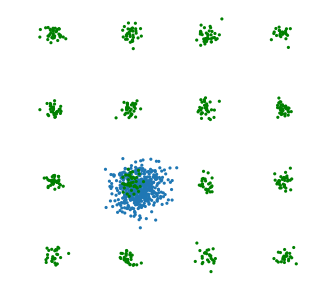

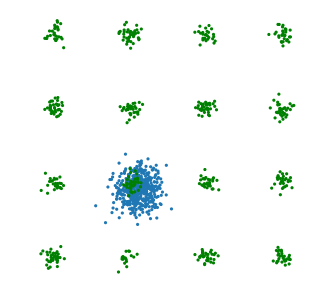

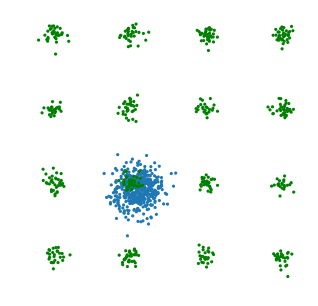

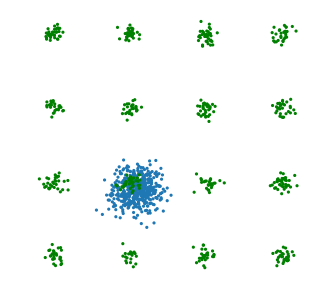

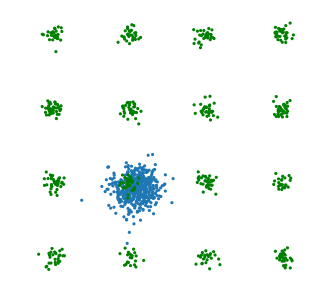

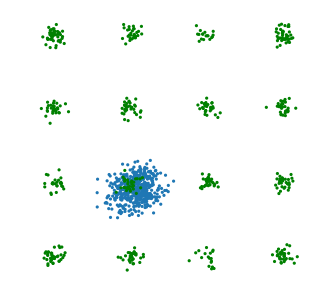

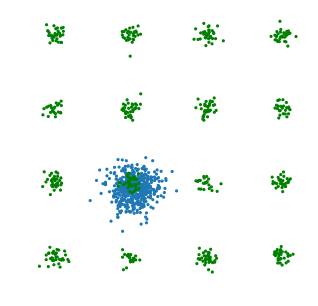

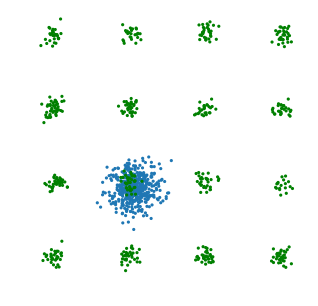

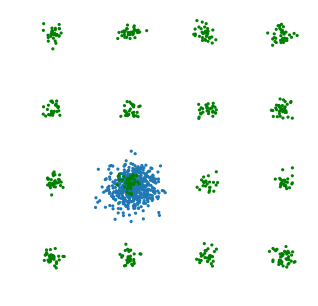

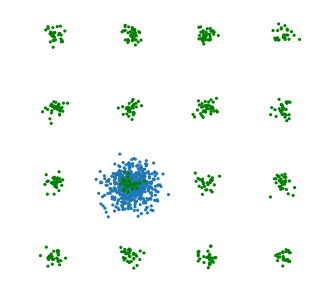

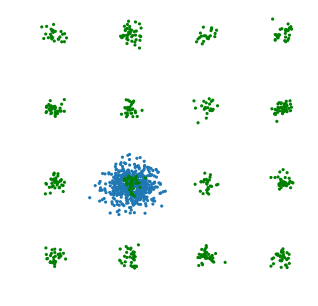

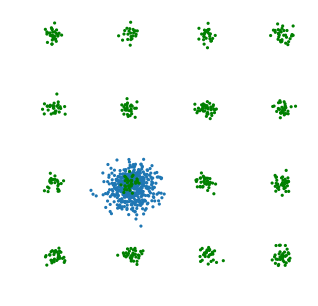

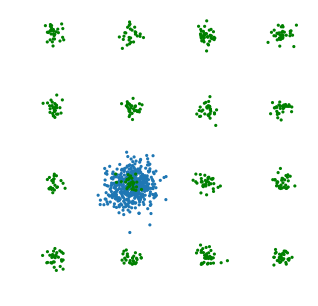

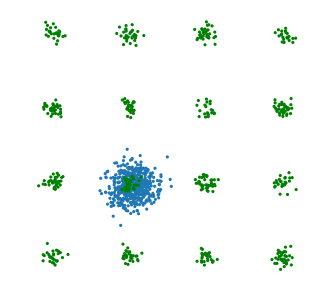

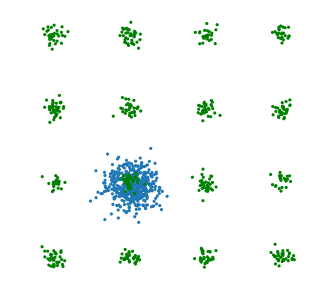

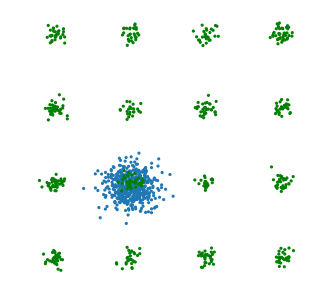

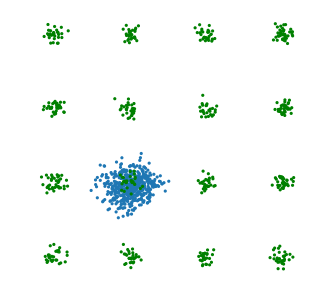

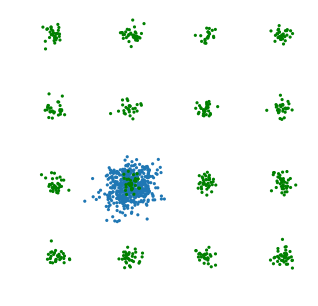

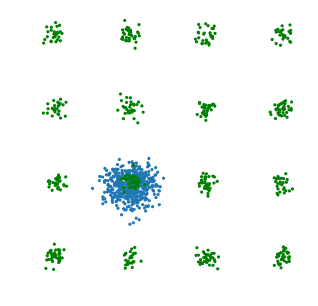

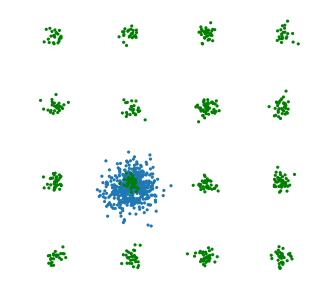

 74%|███████▍  | 60/81 [03:55<01:17,  3.71s/it]

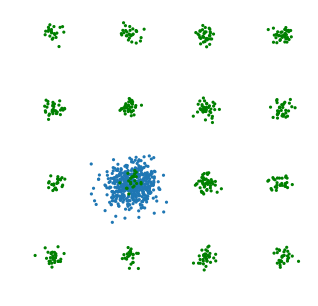

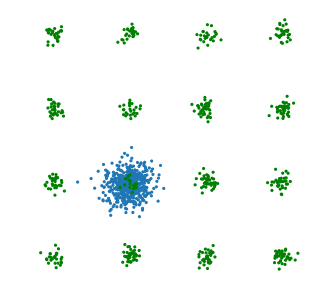

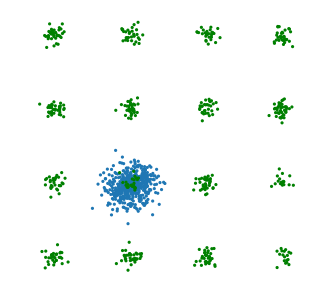

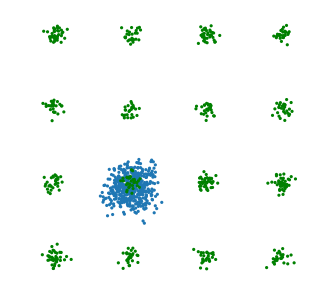

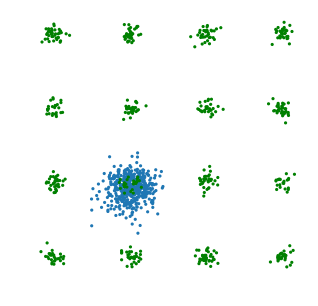

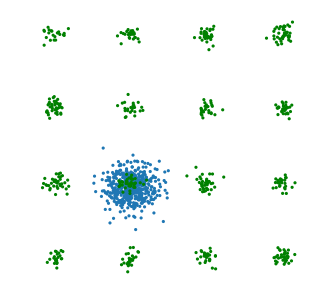

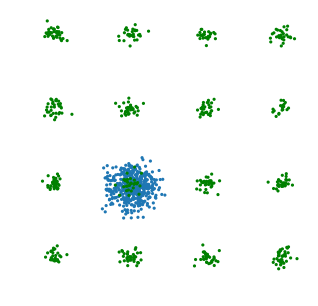

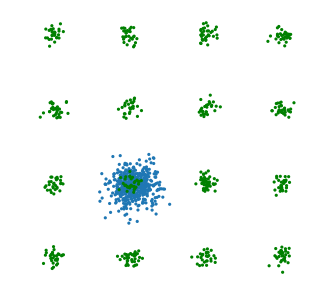

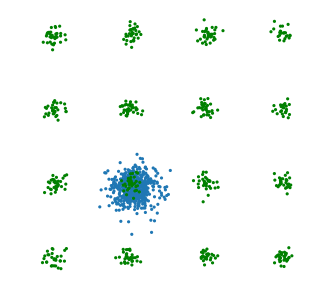

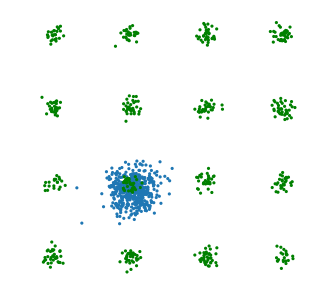

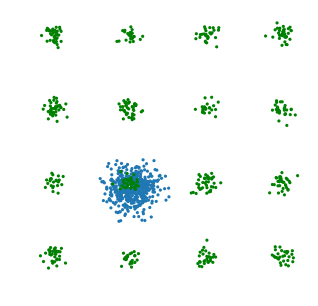

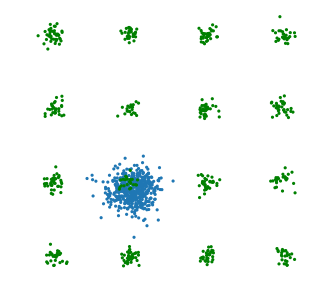

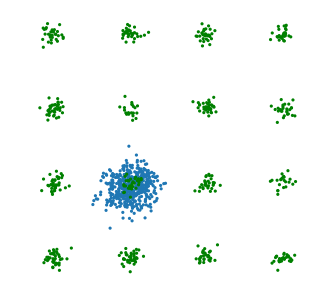

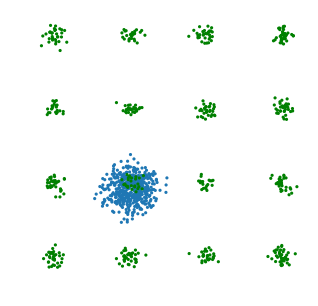

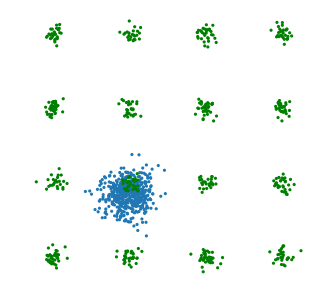

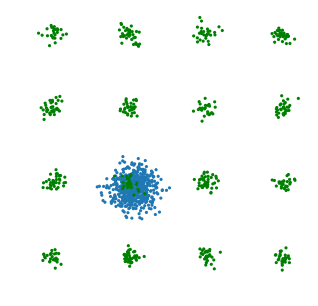

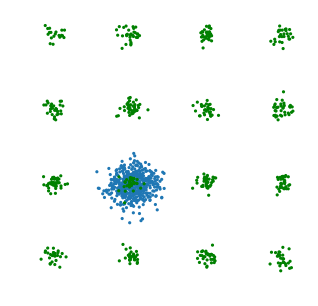

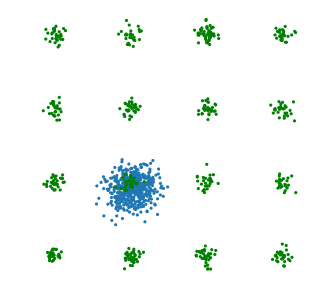

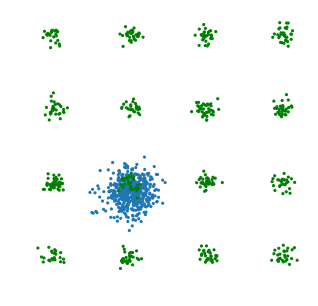

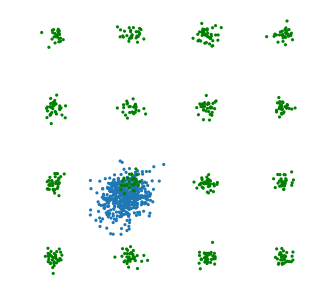

 89%|████████▉ | 72/81 [04:43<00:37,  4.12s/it]

In [ ]:
xmax = 3
fs = []
raw_frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
frame_every = params['frame_every']
for i in tqdm(range(params['max_iter']+1)):
    f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    fs.append(f)
    if (i) % frame_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
        axis('off')
        plt.xlim(-5.5,5.5)
        plt.ylim(-5.5,5.5)
        if generate_movie:
            raw_frames.append(mplfig_to_npimage(fig))
        if (i) % viz_every == 0:
            show()

In [ ]:
np_samples_ = np_samples[::1]
vizu_frames = []
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
# figure(figsize=(2*cols, 2))
fig, ax = plt.subplots()
for i, samps in enumerate(np_samples_):
    ax.clear()
#     if i == 0:
#         ax = subplot(1,cols,1)
#     else:
#         subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
    ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*frame_every))
    if generate_movie:
        vizu_frames.append(mplfig_to_npimage(fig))
gcf().tight_layout()

## Video maker

In [ ]:
raw_clip = mpy.ImageSequenceClip(raw_frames[::], fps=6)
raw_clip.write_videofile("raw_align{}_{}.webm".format(params['align'], params['data']), audio=False)
vizu_clip = mpy.ImageSequenceClip(vizu_frames[::], fps=6)
vizu_clip.write_videofile("vizu_align{}_{}.webm".format(params['align'], params['data']), audio=False)